In [1]:
import pandas as pd

# Load the dataset
data = pd.read_excel('Online Retail.xlsx')

# Display the first few rows of the dataset and its summary
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
from datetime import datetime

# Data Preprocessing and Feature Engineering

# Calculating total spend per invoice
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']

# Creating features for Customer Segmentation
# We will aggregate on CustomerID to create features such as Total Spend, Average Spend, Purchase Count, etc.
customer_data = data.groupby('CustomerID').agg(
    TotalSpend=pd.NamedAgg(column='TotalSpend', aggfunc='sum'),
    AverageUnitPrice=pd.NamedAgg(column='UnitPrice', aggfunc='mean'),
    PurchaseCount=pd.NamedAgg(column='InvoiceNo', aggfunc=pd.Series.nunique),
    MinPurchaseDate=pd.NamedAgg(column='InvoiceDate', aggfunc='min'),
    MaxPurchaseDate=pd.NamedAgg(column='InvoiceDate', aggfunc='max')
).reset_index()

# Adding more features like the range of purchase dates to measure loyalty or engagement over time
customer_data['PurchaseDateRange'] = (customer_data['MaxPurchaseDate'] - customer_data['MinPurchaseDate']).dt.days

# Dropping the min and max purchase dates as they are no longer needed
customer_data.drop(['MinPurchaseDate', 'MaxPurchaseDate'], axis=1, inplace=True)

customer_data.head()

,CustomerID,TotalSpend,AverageUnitPrice,PurchaseCount,PurchaseDateRange
0,12346.0,0.00,1.040000,2,0
1,12347.0,4310.00,2.644011,7,365
2,12348.0,1797.24,5.764839,4,282
3,12349.0,1757.55,8.289041,1,0
4,12350.0,334.40,3.841176,1,0


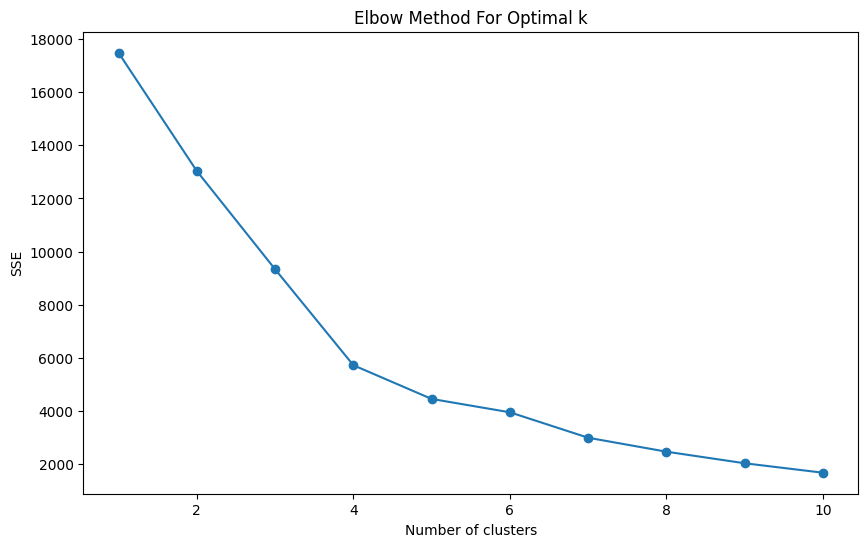

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecting features for K-Means
features = customer_data[['TotalSpend', 'AverageUnitPrice', 'PurchaseCount', 'PurchaseDateRange']]

# Standardizing the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Using the Elbow Method to find the optimal number of clusters
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(features_scaled)
    sse[k] = kmeans.inertia_

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

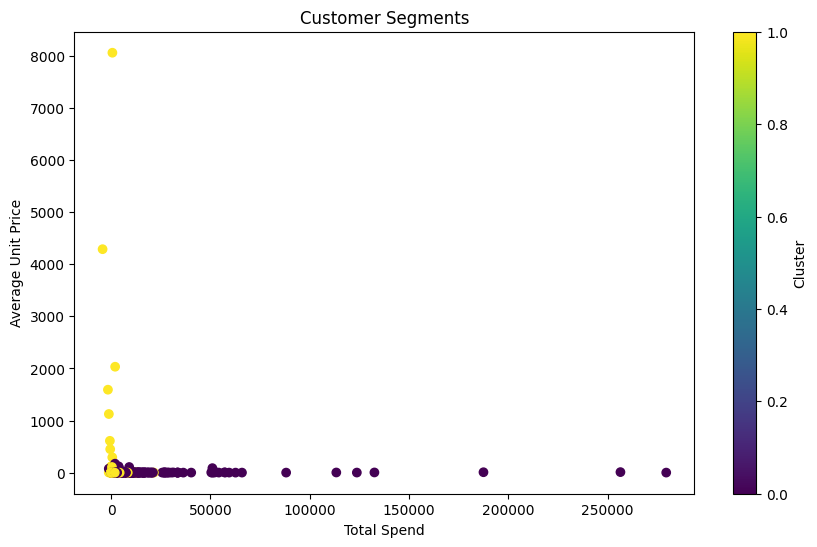

,CustomerID,TotalSpend,AverageUnitPrice,PurchaseCount,PurchaseDateRange,Cluster
0,12346.0,0.00,1.040000,2,0,1
1,12347.0,4310.00,2.644011,7,365,0
2,12348.0,1797.24,5.764839,4,282,0
3,12349.0,1757.55,8.289041,1,0,1
4,12350.0,334.40,3.841176,1,0,1


In [6]:
# Fitting K-Means with 2 clusters due to the small dataset size
kmeans = KMeans(n_clusters=2, random_state=42).fit(features_scaled)

# Assigning the clusters to each customer
customer_data['Cluster'] = kmeans.labels_

# Visualizing the clusters using the first two features
plt.figure(figsize=(10, 6))
plt.scatter(customer_data['TotalSpend'], customer_data['AverageUnitPrice'], c=customer_data['Cluster'], cmap='viridis', marker='o')
plt.title('Customer Segments')
plt.xlabel('Total Spend')
plt.ylabel('Average Unit Price')
plt.colorbar(label='Cluster')
plt.show()

customer_data.head()